In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report # для оценки качества моделей (например, точность)
# confusion_matrix — это таблица, которая показывает, сколько раз модель:
# Угадала правильный класс. Ошиблась и выдала неправильный класс.
from sklearn.metrics import confusion_matrix # для оценки качества моделей (например, точность)
import seaborn as sns #  для красивых графиков


In [2]:
# Загружаем картинки одежды из набора данных
fashion_mnist = tf.keras.datasets.fashion_mnist
# train_images и train_labels — это картинки и их метки для обучения.
# test_images и test_labels — это картинки и их метки для проверки, насколько хорошо работает модель.
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
# Этот код выводит информацию о том, сколько у нас картинок для обучения и тестирования и какого они размера.
# train_images.shape[0] — количество картинок в наборе для обучения. Мы узнаем, сколько у нас примеров (картинок).
# train_images.shape[1:] — размер каждой картинки в пикселях (высота и ширина).
# test_images.shape[0] — количество картинок в наборе для проверки (тестов).
# test_images.shape[1:] — размер тестовых картинок в пикселях.

print(f'Train set: {train_images.shape[0]} examples, {train_images.shape[1:]} pixels,\nTest set: {test_images.shape[0]} examples, {test_images.shape[1:]} pixels')



Train set: 60000 examples, (28, 28) pixels,
Test set: 10000 examples, (28, 28) pixels


In [ ]:
# У нас 60,000 картинок для обучения модели и 10,000 картинок для тестирования. Это хороший объём данных, чтобы научить модель распознавать разные виды одежды.
# Каждая картинка имеет размер 28x28 пикселей, что означает, что изображения маленькие и чёрно-белые (без цвета). Модель сможет быстрее учиться с такими простыми изображениями.
# То что картинка чёрно-белые понятно из:Обычно цветные изображения имеют три канала (RGB: красный, зелёный, синий), то есть указывают размеры как (высота, ширина, каналы).
# Но здесь указано только (28, 28), значит, изображение чёрно-белое (одноканальное), где каждый пиксель — это просто оттенок серого.

In [4]:
# Название колонок в наборе данных fashion_mnist — это метки классов, которые обозначают тип одежды.
# Эти метки представлены в виде чисел (от 0 до 9), где каждому числу соответствует определённая категория одежды.
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Выводим названия классов
for index, name in enumerate(class_names):
    print(f'Класс {index}: {name}')

Класс 0: T-shirt/top
Класс 1: Trouser
Класс 2: Pullover
Класс 3: Dress
Класс 4: Coat
Класс 5: Sandal
Класс 6: Shirt
Класс 7: Sneaker
Класс 8: Bag
Класс 9: Ankle boot


In [5]:
# Функция normalize делит каждое значение пикселя на 255.
# Пиксели на картинке могут иметь значение от 0 до 255 (0 — это чёрный, 255 — это белый).
# Когда мы делим на 255, все значения становятся от 0 до 1. Это называется нормализация.
def normalize(images):
  return images / 255.
# Мы нормализуем картинки для обучения и тестирования, чтобы все значения пикселей были в диапазоне от 0 до 1.
train_images = normalize(train_images)
test_images = normalize(test_images)
# Нормализация помогает моделям работать лучше, потому что значения данных теперь маленькие и более удобные для вычислений. Модель быстрее и точнее учится на таких данных.

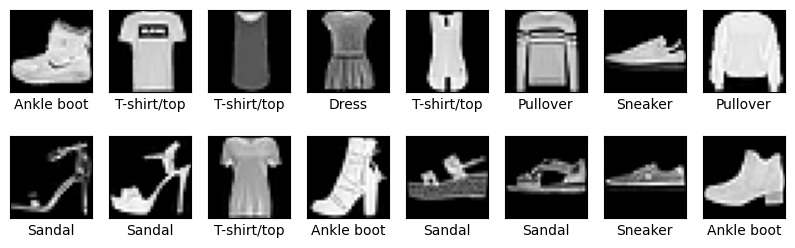

In [6]:
plt.figure(figsize=(10,3))
# Цикл рисует 16 картинок.
for i in range(16):
    # делит область на 2 строки и 8 столбцов и добавляет картинки по одной.
    plt.subplot(2, 8, i+1)
    # Отключаем оси и сетку, чтобы не было лишних линий и чисел вокруг картинок.
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # Показываем картинку. Используем чёрно-белую гамму (cmap='gray'), чтобы сделать изображение понятным.
    plt.imshow(train_images[i], cmap='gray')
    # Подписываем каждую картинку названием класса
    plt.xlabel(class_names[train_labels[i]])
plt.show()
# Мы можем увидеть 16 разных картинок одежды из набора данных и их названия. Это полезно, чтобы понять, что именно видит и учит модель:

In [7]:
# Создаём специальный класс myCallback, который будет отслеживать обучение модели и принимать решения по ходу процесса.
class myCallback(tf.keras.callbacks.Callback):
  # on_epoch_end — это функция, которая выполняется в конце каждой эпохи (когда модель прошла один круг обучения на всех данных). Она проверяет, как идут дела с точностью.
  def on_epoch_end(self, epoch, logs={}):

    # мы сравниваем точность модели на обучающих данных (accuracy) с точностью на проверочных данных (val_accuracy).
    # Если разница больше 5%, это плохо, потому что модель слишком хорошо запомнила обучающие данные, но не справляется с новыми (проверочными).
    # это называется переподгонка - overfitting (когда модель учится слишком хорошо на тренировочных данных, но не может обрабатывать новые данные).
    if logs.get('accuracy') - logs.get('val_accuracy') >= 0.05:
      # Если разница больше 5%, то обучение останавливается.
      print(f"\nThe difference between train accuracy and validation more than 5% so cancelling training!")
      self.model.stop_training = True

# Создаём объект этого класса, чтобы потом передать его в модель для отслеживания процесса обучения.
callbacks = myCallback()


# Этот код следит за тем, чтобы модель не переучивалась.
# Если точность на обучении сильно отличается от точности на проверке, обучение остановится. Это помогает сделать модель более гибкой и правильной.

In [8]:
# tf.keras.callbacks.ReduceLROnPlateau — это функция, которая помогает улучшить обучение модели, уменьшая скорость обучения, если модель не улучшается.
# monitor='val_accuracy' — мы следим за точностью на проверочных данных. Если эта точность не улучшается, мы будем менять скорость обучения.
# factor=0.5 — если точность не улучшается, скорость обучения уменьшится в 2 раза (умножается на 0.5).
# patience=3 — мы будем ждать 3 эпохи. Если точность не улучшится за эти 3 эпохи, скорость обучения будет уменьшена.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3)

# Если модель не улучшает свои результаты на проверочных данных в течение нескольких эпох, скорость обучения будет снижена. Это может помочь модели лучше обучаться.

In [9]:
# tf.keras.models.Sequential создаёт модель для машинного обучения, которая будет последовательно обрабатывать данные.
# Sequential — это тип модели, где слои идут один за другим. Каждый слой получает данные от предыдущего и передаёт их следующему.
model = tf.keras.models.Sequential([
  # Flatten превращает каждую картинку размером 28x28 пикселей в один длинный ряд, чтобы модель могла её обработать.
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  # добавляет слой с 512 нейронами и использует функцию ReLU для активации. Это помогает модели учиться на данных.
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  # случайно отключает 10% нейронов во время обучения, чтобы модель не переучивалась.
  tf.keras.layers.Dropout(0.1),

  # Добавляем ещё два слоя с 256 и 128 нейронами, и Dropout(0.1) для предотвращения переобучения.
  tf.keras.layers.Dense(256, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),

  # добавляет последний слой с 10 нейронами, каждый из которых показывает вероятность того, что картинка относится к одному из 10 классов одежды.
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
# показывает информацию о модели, сколько слоев, какие у них размеры и параметры.
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 567,434 (2.16 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Вот что можно понять из ↑:

# Количество слоёв и их размеры:
  # Flatten превращает картинки в один ряд из 784 значений.
  # Dense слои:
    # Первый слой: 512 нейронов.
    # Второй слой: 256 нейронов.
    # Третий слой: 128 нейронов.
    # Последний слой: 10 нейронов (для 10 классов одежды).

# Параметры модели:
  # Всего параметров: 567,434.
  # Все параметры можно обучать (то есть, они будут изменяться во время тренировки).

# Модель имеет несколько слоёв, и все параметры будут изменяться во время обучения. Она имеет 567,434 параметра, которые помогут ей научиться распознавать разные виды одежды.

In [11]:
# используем оптимизатор Adam с скоростью обучения 0.003. Это помогает модели учиться и улучшаться.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.003),
              # выбираем функцию потерь sparse_categorical_crossentropy. Это помогает модели оценивать, насколько хорошо она предсказывает правильный класс одежды.
              loss = 'sparse_categorical_crossentropy',
              # следим за точностью модели. Это показывает, насколько часто модель правильно угадывает класс одежды.
              metrics=['accuracy'])
# Модель настроена на обучение с помощью оптимизатора Adam, оценивает ошибки с помощью функции потерь, и мы будем отслеживать точность её предсказаний.

In [ ]:
# model.fit — это функция, которая обучает модель на тренировочных данных.
# train_images и train_labels - обучаем модель на картинках и метках из тренировочного набора.
history = model.fit(train_images,
          train_labels,
          # проверяем модель на тестовых данных (чтобы увидеть, как она справляется с новыми данными)
          validation_data=(test_images, test_labels),
          # Модель обрабатывает 200 картинок за раз. Это помогает ускорить обучение.
          batch_size=200,
          # Модель проходит 100 полных циклов обучения на всех данных.
          epochs=100,
          # используем два обратных вызова:
          # callbacks: останавливает обучение, если модель переобучается.
          # reduce_lr: уменьшает скорость обучения, если модель не улучшает точность.
          callbacks=[callbacks, reduce_lr])

# Модель обучается на тренировочных данных, проверяется на тестовых данных и
# проходит 100 циклов обучения. Мы используем обратные вызовы, чтобы улучшить процесс обучения и предотвратить проблемы.

Epoch 1/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.7274 - loss: 0.7489 - val_accuracy: 0.8499 - val_loss: 0.4132 - learning_rate: 0.0030
Epoch 2/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8565 - loss: 0.3941 - val_accuracy: 0.8603 - val_loss: 0.3832 - learning_rate: 0.0030
Epoch 3/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8710 - loss: 0.3487 - val_accuracy: 0.8560 - val_loss: 0.3847 - learning_rate: 0.0030
Epoch 4/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8776 - loss: 0.3339 - val_accuracy: 0.8712 - val_loss: 0.3576 - learning_rate: 0.0030
Epoch 5/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8817 - loss: 0.3158 - val_accuracy: 0.8730 - val_loss: 0.3468 - learning_rate: 0.0030
Epoch 6/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8864 - loss: 0.3056 - val_accuracy: 0.8775 - val_loss: 0.3477 - learning_rate: 0.0030
Epoch 7/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8880 - l

In [ ]:
# Вот что можно понять из ↑:

# Точность и ошибка:
# Точность модели (accuracy) на тренировочных данных постепенно увеличивается с каждым циклом (эпохой). Например, на 1-й эпохе точность была 72.59%, а на 36-й достигла 95.21%.
# Ошибка (loss) на тренировочных данных уменьшается, что хорошо, так как это означает, что модель обучается лучше.

# Проверка на тестовых данных:
# Точность на тестовых данных(val_accuracy) также растет, но не так быстро, как на тренировочных. На 1-й эпохе была 83.72%, а на 36-й 90.15%.
# Ошибка на тестовых(val_loss) данных колебалась, но в целом уменьшалась, что также хорошо.

# Скорость обучения:
# Скорость обучения (learning rate) постепенно уменьшалась. Это делается для того, чтобы модель более точно подстраивалась под данные.

# Остановка обучения:
# Обучение было остановлено на 36-й эпохе, потому что разница между точностью на тренировочных и тестовых данных превысила 5%.
# Это означает, что модель могла начать переобучаться.

# Модель обучалась хорошо и достигла высокой точности. Однако, чтобы избежать переобучения, обучение было остановлено,
# когда точность на тренировочных данных стала значительно лучше, чем на тестовых данных.

In [13]:
# вызывает встроенный инструмент для проверки, чтобы узнать, насколько хорошо модель работает на тестовых данных.
model.evaluate(test_images, test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9005 - loss: 0.3577


[0.35622668266296387, 0.9013000130653381]

In [ ]:
# ↑:
# accuracy: 0.8993: Это точность модели на тестовых данных. Модель правильно предсказывает класс на 89.93% тестовых изображений.
# loss: 0.3581: Это ошибка модели на тестовых данных. Чем меньше это значение, тем лучше модель.
# Формат [0.35504332184791565, 0.9014999866485596] -
# это значения ошибки (loss) и точности (accuracy) в виде списка. Значения показывают ту же информацию, что и в строке вывода.

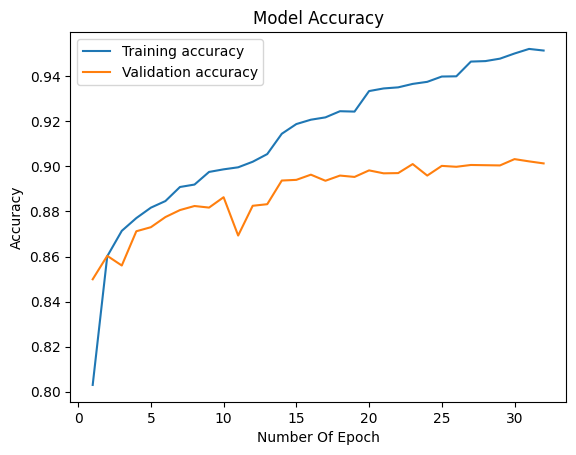

In [14]:
# Этот код рисует график, который показывает, как менялась точность модели (accuracy) в процессе обучения.
train_accuracy = history.history['accuracy'] # содержат точность модели на тренировочных данных
val_accuracy = history.history['val_accuracy'] # содержат точность модели на тестовых данных
# рисует две линии на графике: одну для тренировочной точности и одну для тестовой точности
plt.plot(list(range(1, len(train_accuracy) + 1)), train_accuracy, label='Training accuracy')
plt.plot(list(range(1, len(train_accuracy) + 1)), val_accuracy, label='Validation accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Number Of Epoch')
plt.ylabel('Accuracy')
plt.show()

# можно увидеть, как улучшалась точность модели на тренировочных и тестовых данных с течением времени (по количеству эпох).
# если бы линия для тестовой точности шла вниз или колебалась, означало бы, что модель плохо обобщает новые данные или переобучается.

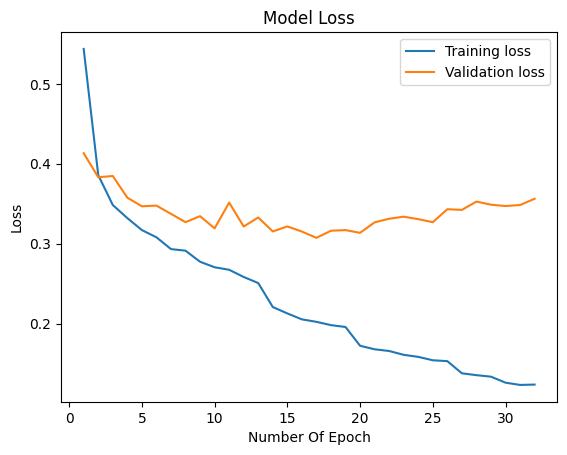

In [15]:
# Этот код рисует график, который показывает, как менялась ошибка модели (loss) в процессе обучения.
train_loss = history.history['loss'] # содержат ошибку модели на тренировочных данных
val_loss = history.history['val_loss'] # содержат ошибку модели на  тестовых данных
plt.plot(list(range(1, len(train_loss) + 1)), train_loss, label='Training loss')
plt.plot(list(range(1, len(train_loss) + 1)), val_loss, label='Validation loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Number Of Epoch')
plt.ylabel('Loss')
plt.show()

# можно увидеть, как ошибка модели на тренировочных и тестовых данных изменялась с течением времени (по количеству эпох).
# Если ошибка на тестовых данных растет или остается высокой, это может означать, что модель переобучается или плохо обобщает данные.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


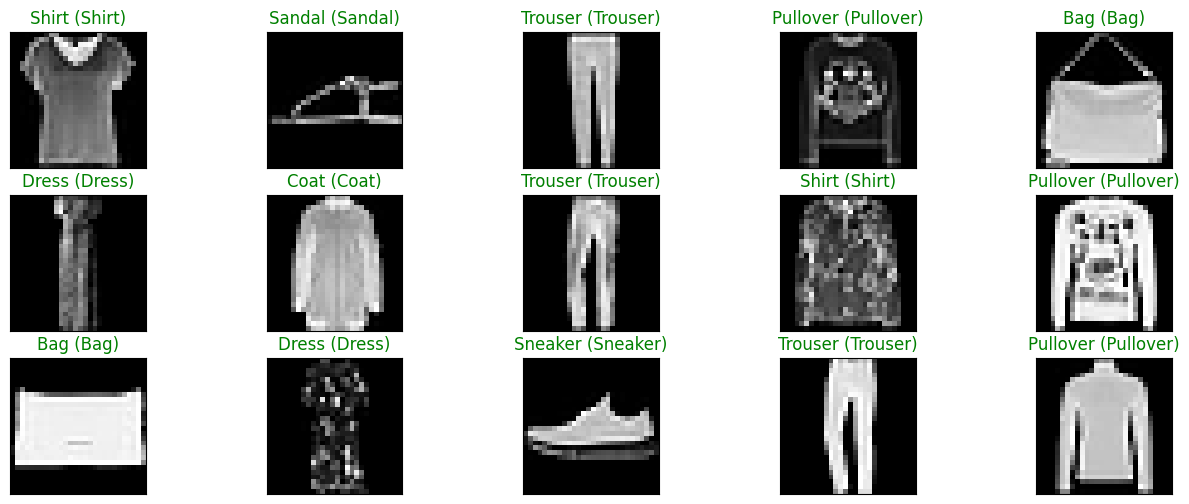

In [16]:
# Этот код показывает изображения из тестового набора и сравнивает предсказанные и реальные метки.
# вычисляет, какие классы модель предсказывает для каждого изображения.
predictions = model.predict(test_images)

figure = plt.figure(figsize=(16, 6))
# случайным образом выбирает 15 изображений из тестового набора.
display_images = np.random.choice(test_images.shape[0], size=15, replace=False)
for i, index in enumerate(display_images):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # каждое изображение отображает в виде матрицы
    ax.imshow(test_images[index], cmap='gray')
    # содержит предсказанный класс для изображения
    predict_index = np.argmax(predictions[index])
    #print(f'{predict_index}: {class_names[predict_index]}')
    # содержит истинный класс для изображения
    true_index = test_labels[index]
    # устанавливает заголовок для каждого изображения, показывая предсказанный класс
    #  (зеленым цветом, если предсказание верное) и истинный класс (красным цветом, если предсказание неверное).
    ax.set_title("{} ({})".format(class_names[predict_index],
                                  class_names[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

# Модель ошибается на изображениях с T-shirt/top(Shirt). Возможно, ей сложно различить этот класс среди других.
# Для улучшения модели можно:
  # Проверить, достаточно ли данных для этого класса.
  # Попробовать различные архитектуры модели или методы регуляризации.
  # Изучить ошибки и попробовать улучшить предобработку данных.

In [17]:
# превращает предсказания модели в метки классов. Он находит индекс класса с наибольшей вероятностью для каждого изображения
predicted_labels = np.argmax(predictions, axis=1)
# создает отчет о точности работы модели. В отчете сравниваются настоящие метки test_labels с предсказанными метками predicted_labels. target_names показывает названия классов.
report = classification_report(test_labels, predicted_labels, target_names=class_names)
print(report)

# Код показывает, как хорошо модель угадывает классы для тестовых данных.
# В отчете можно увидеть точность, полноту и F1-меру для каждого класса.

# Точность (Precision): Как часто модель правильно угадывает, когда она предсказывает этот класс.
# Например, для T-shirt/top точность 0.84 означает, что 84% всех предсказаний этого класса оказались верными.

# Полнота (Recall): Как хорошо модель находит все примеры этого класса.
# Например, для Trouser полнота 0.98 означает, что 98% всех истинных примеров этого класса были найдены моделью.

# F1-меры (F1-score): Среднее значение точности и полноты. Например, для Shirt F1-мера 0.73 означает, что модель не так хорошо работает для этого класса.

# Точность на всех данных (Accuracy): В целом модель правильно предсказывает 90% всех примеров в тестовых данных.

# Модель хорошо работает для большинства классов.
# Наименьшие значения F1-меры для Shirt и Pullover показывают, что эти классы модель предсказывает хуже, чем другие.
# В целом, модель имеет высокую точность и полноту для большинства классов.

              precision    recall  f1-score   support

 T-shirt/top       0.84      0.87      0.85      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.83      0.82      0.82      1000
       Dress       0.90      0.91      0.90      1000
        Coat       0.81      0.85      0.83      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.76      0.71      0.73      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.98      0.97      0.98      1000
  Ankle boot       0.97      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



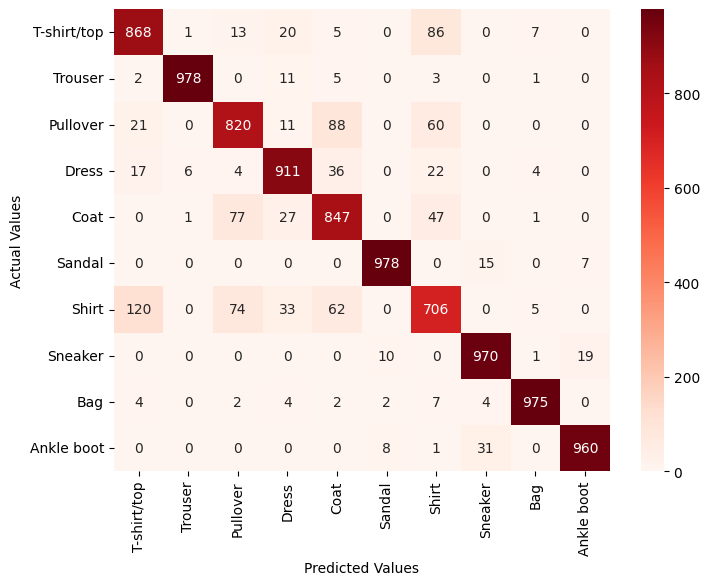

In [18]:
# Код строит матрицу ошибок (confusion matrix), которая показывает, как часто модель ошибается в своих предсказаниях для разных классов.

# создает матрицу ошибок, где строки показывают истинные метки (что на самом деле), а столбцы — предсказанные метки (что модель предсказала).
cm = confusion_matrix(test_labels, predicted_labels)


plt.figure(figsize=(8, 6))
# рисует эту матрицу в виде цветной таблицы. Цвета показывают, сколько раз модель предсказала каждый класс, а текст — точное количество.
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

# Диагональная линия (где x = y) показывает количество правильных предсказаний. Чем больше цифра, тем лучше модель для этого класса.
# Не диагональные элементы показывают, сколько раз модель ошиблась, предсказав один класс вместо другого. Например, если модель ошибается,
# предсказав Shirt вместо T-shirt/top, то это число будет в ячейке, соответствующей Shirt по строке и T-shirt/top по столбцу.

In [ ]:
# По Classification Report (report = classification_report) и Confusion Matrix (cm = confusion_matrix) можно сделать следующие выводы:

# Качество модели:
  # Точность (Precision): Высокая точность для большинства классов означает, что модель хорошо справляется с распознаванием конкретных классов, таких как Trouser, Sandal, Bag.
  # Полнота (Recall): Высокая полнота показывает, что модель находит большинство объектов этого класса. Например, для Trouser и Sandal полнота почти 100%,
  # что означает, что модель практически не пропускает эти классы.
  # F1-Score: Хороший показатель, так как он учитывает и точность, и полноту. Классы Trouser, Sandal, и Bag имеют высокие значения F1-Score, что говорит о том,
  # что модель их распознает хорошо.

# Проблемные классы:
  # Shirt: Низкая точность и полнота у Shirt указывают на проблемы с распознаванием этого класса. Модель часто путает его с другими классами.
  # T-shirt/top и Pullover: Модель иногда путает T-shirt/top и Pullover, что видно из матрицы ошибок. Эти классы имеют близкие характеристики,
  # и модель может ошибаться в их различении.

# Общая производительность модели:
  # Точность (Accuracy): В целом, модель имеет точность 90%, что означает, что она правильно классифицирует 90% изображений.
  # Макро- и взвешенные усреднения: Хорошие значения для макро- и взвешенного усреднения показывают, что модель в целом справляется с задачей.

 Модель хорошо справляется с большинством классов, особенно с Trouser, Sandal, и Bag, но есть проблемы с точностью и полнотой для Shirt, и модель иногда путает T-shirt/top и Pullover. (согласно Confusion Matrix можно увидеть, что чаще всего наша модель по ошибке предполагает T-shirt/Top вместо Shirt).